<img src="http://www.eurocean.org/np4/file/157/1.png" alt="drawing" width="200"/>


# Acoustic service
#### Introduction
The aim of this notebook is to give a introduction to processing of passive acoustic data.

This notebook demonstrates the use of PAMGuide for processing of passive acoustic data. PAMGuide, written by Nathan Merchant, is available for both MATLAB and R.

* https://sourceforge.net/projects/pamguide/
* http://onlinelibrary.wiley.com/doi/10.1111/2041-210X.12330/suppinfo

A detailed description of the usage of PAMGuide is described in the supplementary material of the 2015 paper, available here: https://besjournals.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2F2041-210X.12330&file=mee312330-sup-0001-AppendixS1.pdf

This notebook has been created as a part of INTAROS.

Espen Storheim, NERSC. 2019-10-08.

### Setup
All the relevant files are available torugh this notebook.

In [3]:
# Load the packages etc. from the main PAMGuide script. Need to run this command every time changes are made in PAMGuide.R.
source('pamguide_vectorinput.R')

## Running PAMGuide with test data
Two test files are provided with PAMGuide, which allows the user to verify the operation of the software.

There are two test files (WAV-files) provided with PAMGuide:

* Sine\_10s\_48kHz\_+-0.5wav
* WhiteNoise\_10s\_48kHz\_+-0.5.wav

Both are recorded with a sampling frequency of 48 kHz, which corresponds to 48000 samples per second. 

The vertical resolution of the sampling (i.e. the bit resolution), is obtained automatically from the WAV file.

In [4]:
# Reproduce Figure 2 from the supplementary material:
atype = "Broadband"
plottype = "Both"
ctype = "TS"
envi = "Wat"
G = 0
vADC = 2
Mh = -200
ifname = "WhiteNoise_10s_48kHz_+-0.5.wav"
calib = 1
plottype="Time"

PAMGuide(fullfile=ifname,calib=calib, atype=atype, plottype=plottype, Mh=Mh, envi=envi, ctype=ctype, G=G, vADC=vADC)

ERROR: Error in readWave(fullfile, header = TRUE): File 'WhiteNoise_10s_48kHz_+-0.5.wav' does not exist.


File name: Sine_10s_48kHz_+-0.5.wav 
File length: 480000 samples = 10 s
Analysis type: PowerSpec 
Plot type: Stats 
Underwater measurement
Hydrophone sensitivity: -200 dB re 1 V/uPa
Preamplifier gain: 0 dB
ADC peak voltage: 2 V
Time segment length: 48000 samples = 1 s
Window function: Hann 
Window overlap: 50 %
Loading input file... done in 0.043 s.
System sensitivity correction factor, S =  -206.0  dB
Computing power spectrum...done in 0.154 s.
Computing noise level statistics...done in 3.285 s.
Too few time segments (M =  19 , i.e. <1000) for SPD analysis: for SPD, use a longer file or shorter time segment length (N).


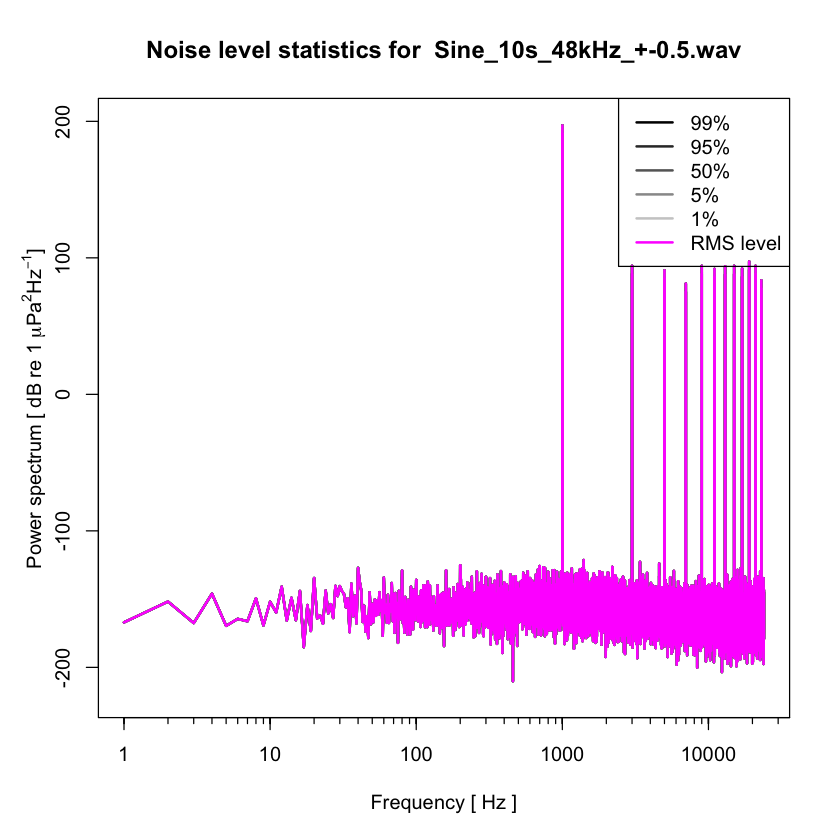

In [118]:
# Reproduce Figure 2 from the supplementary material:
atype = "PowerSpec"
ctype = "TS"
envi = "Wat"
G = 0
vADC = 2
Mh = -200
ifname = "Sine_10s_48kHz_+-0.5.wav"
calib = 1
plottype="Stats"

PAMGuide(fullfile=ifname,calib=calib, atype=atype, plottype=plottype, Mh=Mh, envi=envi, ctype=ctype, G=G, vADC=vADC)

# Reading data from the NetCDF format

This is an example of how to read data from a NetCDF file.

As there is no standard for the file format for passive acoustic data, PAMGuide has been rewritten to accept vector input.

The example will cover two different scenarios:
* Reading from a local file
* Reading from an online resource, e.g. a Thredds server

The example data chosen here is a 10 minute long passive acoustic recording, made in the Fram Strait in 2013 as a part of the WIFAR project (ref). The example will also illustrate how calibration information is applied in order to get the actual measurement.

The data is available here:
https://archive.norstore.no/pages/public/datasetDetail.jsf?id=10.11582/2017.00012



### Load and install relevant packages/libraries
The ncdf4 package must be installed in order to read and write NetCDF files. Try to import it - if not, install it from the repository.

In [7]:
require(ncdf4)
library(ncdf4)

Loading required package: ncdf4


#### Open the NetCDF file:

In [10]:
# Name of the NetCDF file:
fname <- "../../rcv_238064010.nc"

# Note: The filename is used for admin purposes only. The file is not loaded inside PAMGuide.

In [11]:
# Open the NetCDF file for reading:
ncin <- nc_open(fname)


In [13]:
# Get the attributes:
nc_atts <- ncatt_get(ncin,0)

# Print some of the attributes:
print(nc_atts$summary)
print(nc_atts$data_assembly_center)

[1] "WIFAR/UNDER-ICE acoustic recording from an integrated ice station in the Fram Strait marginal ice zone"
[1] "CONSORTIA/INSTITUTIONS>>>>NERSC >Nansen Environmental and Remote Sensing Centre>http://www.nersc.no/main/index2.php"


#### Read information from the NetCDF file
It's always nice to get an overview of the contents of a NetCDF file, and also to determine the names of relevant parameters to be extracted. This is easily accomplished:

In [124]:
# Get an overview of the NetCDF file:
print(ncin)

File ui1_rcv_572150109.nc (NC_FORMAT_CLASSIC):

     25 variables (excluding dimension variables):
        int start_time[]   
            long_name: Sampling start time
            calendar: julian
            units: seconds since 2013-12-31, 00:00:00 UTC
        float sample_rate[]   
            long_name: Data sample rate
            units: Hz
        short reception_flags[]   
            long_name: Reception flags
            units: bitmap
        byte time_not_set[]   
            long_name: State of timesetting at commencement of data acquisition
            units: boolean
        byte sd_indexed[]   
            long_name: State of SD sector indexing
            units: boolean
        int sd_dropouts[]   
            long_name: SD card dropouts
            units: number of dropped sector regions
        int f_pwrup[]   
            long_name: Cumulative number of powerups
            units: counts
        int f_pwrdown[]   
            long_name: Cumulative number of powerdown

The NetCDF file contains quite a lot of information. The minimum information about an acoustic recording is 1) the sampling frequency, and 2) the sample values. This allows the user to plot an UNCALIBRATED waveform, which in turn can be used for a relative analysis.

Other parameters of interest are e.g. the time of the recording (absolute), position (longitude/latitude) depth of the hydrophone, and any calibration information to obtain absolute pressure values.

In [14]:
# Sampling frequency [Hz]:
fs <- ncvar_get(ncin, "sample_rate", verbose = F)
fs
# Time at start of recording:
tstart <- ncvar_get(ncin, "start_time", verbose = F)
tstart
# Samples:
y <- ncvar_get(ncin, "samples", verbose = F)

# Get the number of samples in the recording.
Nsamp <- length(y)
Nsamp

[1] 3906.25

[1] 20587210

[1] 2277216

### Applying calibration information
The calibration information for this acoustic recording is stored in a comment in the NetCDF file, and must be entered manually.

PAMGuide supports calibration information as input parameters, so there is no need to input a pressure waveform.



In [15]:
print(nc_atts$comment)

[1] "The necessary parameters for processing of the data are Bits-to-Volts conversion factor=2.5/2^23, Amplitude gain=10^(12/20),Hydrophone sensitivity=10^(-168/20)"


In [16]:
# Digitizer:
Nbit = 24

# Sensitivity of the hydrophone:
HySens <- -168 # dB re 1 uPa/V

# Gain of the voltage amplifier:
Gain <- 12 # dB re 1 V/V

vADC <- 2.5

# Digitizer information:
B2V <- vADC/2^(Nbit - 1) # Volt/Bit



Warning message in plot.xy(xy, type, ...):
“plot type 'lines' will be truncated to first character”

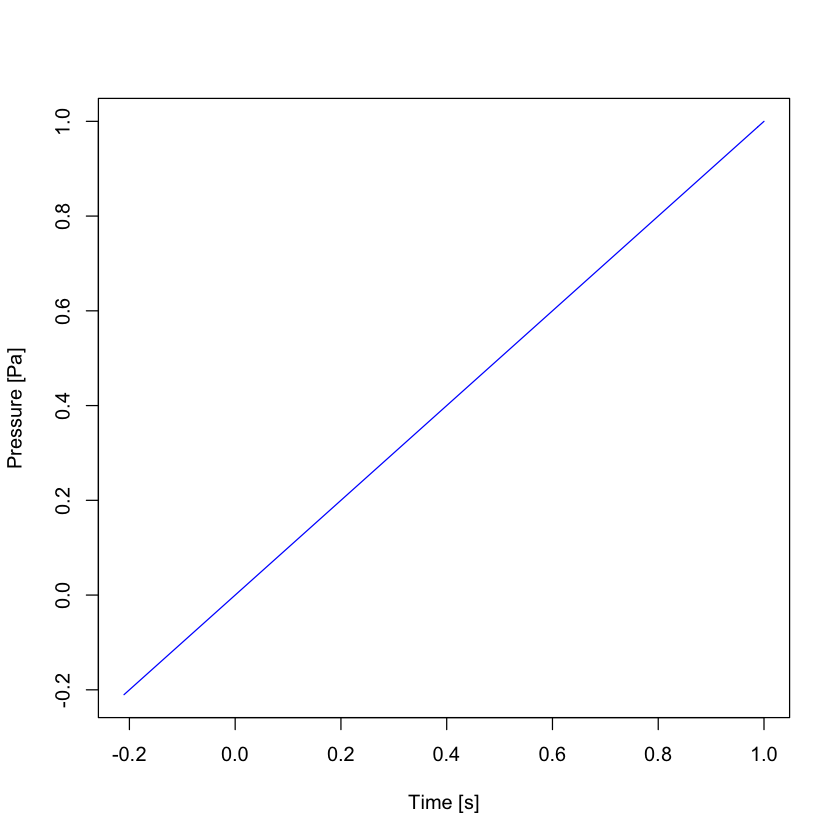

In [17]:
# System correction factor:
S <- HySens + Gain + 20*log10(1/vADC)

# Reload the samples to ensure fresh values.
y <- ncvar_get(ncin, "samples", verbose = F)

# Scale by the bits:
y <- y/(2^(Nbit - 1))

# Add the system correction factor to get pressure:
p <- y/(10^(S/20))

# Convert from uPa to Pa:
p <- p/1e6



### Set up the timebase
The time vector is relative to the start of the recording. If absolute time is required, adding the start time is necessary. In the NetCDF file, the start time is given in seconds since 2011-12-31 00:00:00 UTC.

The file name has a format "rcv_YeardayHourMinuteSecond", which can be used for a verification. Yearday 1 in 2012 is January 1st. Yearday 238 in 2012 (leap year) is August 25. 

The interval between each sample, dt, is just the inverse of the sampling frequency.

Warning message in strptime(x, format, tz = tz):
“unknown timezone 'zone/tz/2019c.1.0/zoneinfo/Europe/Oslo'”

[1] "Recording start: 2014-08-26 06:40:10"

Warning message in plot.xy(xy, type, ...):
“plot type 'lines' will be truncated to first character”

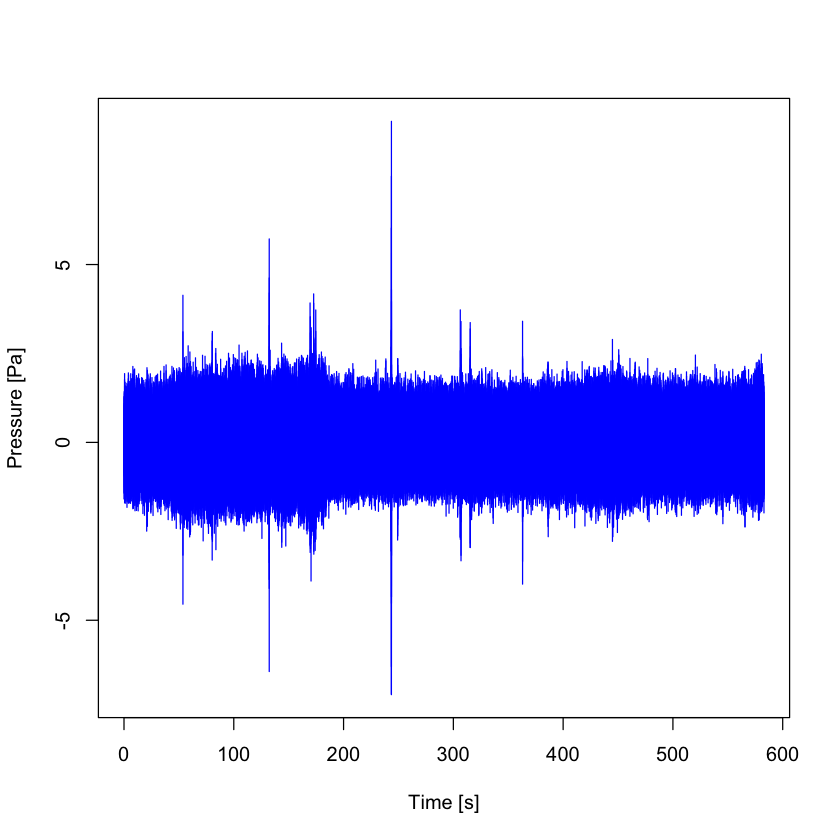

In [18]:
# Set up the reference time:
tref <- as.POSIXct("2013-12-31 00:00:00", format="%Y-%m-%d %H:%M:%S", tz="UTC")

# Add the start time to the reference time:
t0 <- tref + tstart

# Print the start time fof the recording:
sprintf("Recording start: %s", t0)

# Set up the time vector from t0 with a timestep of dt seconds. 
dt <- 1/fs
t <- seq(0, Nsamp-1)*dt


#T0 <- as.POSIXct(t0, format = "%Y%m%dT%H%M%SZ", tz = "UTC")


# Make a plot of the pressure vs time:
plot(t, p, col="blue",type="lines", xlab="Time [s]", ylab="Pressure [Pa]")

## Examples of the different analysis methods

In [19]:
# Set up the parameters for the processing:

# Set to water. Reference pressure is 1 uPa.
envi = "Wat"

# Peak voltage of the ADC:
vADC = 2.5

# Sensitivity of the hydrophone, in dB re 1 Volt/uPa.
Mh = -168

# Preamp gain:
G = 12

# Flag: Use calibration data:
calib = 1

# Set calibration type to TS = Technical Specification:
ctype = "TS"

# Flag: provide the input waveform as a vector.
isvector = 1

# Bit resolution of ADC:
Nbit = 24

# Write output file:
outwrite = 0

### Example: PowerSpec analysis type

File length: 2277216 samples = 582.9673 s
File name: rcv_238064010.nc 
File length: 2277216 samples = 582.9673 s
Analysis type: PowerSpec 
Plot type: Both 
Underwater measurement
Hydrophone sensitivity: -168 dB re 1 V/uPa
Preamplifier gain: 12 dB
ADC peak voltage: 2.5 V
Time segment length: 3906.25 samples = 1 s
Window function: Hann 
Window overlap: 50 %
Loading input file... done in 0.017 s.
System sensitivity correction factor, S =  -164.0  dB
Computing power spectrum...done in 0.7 s.
Plotting...done in 0.565 s.
Computing noise level statistics...

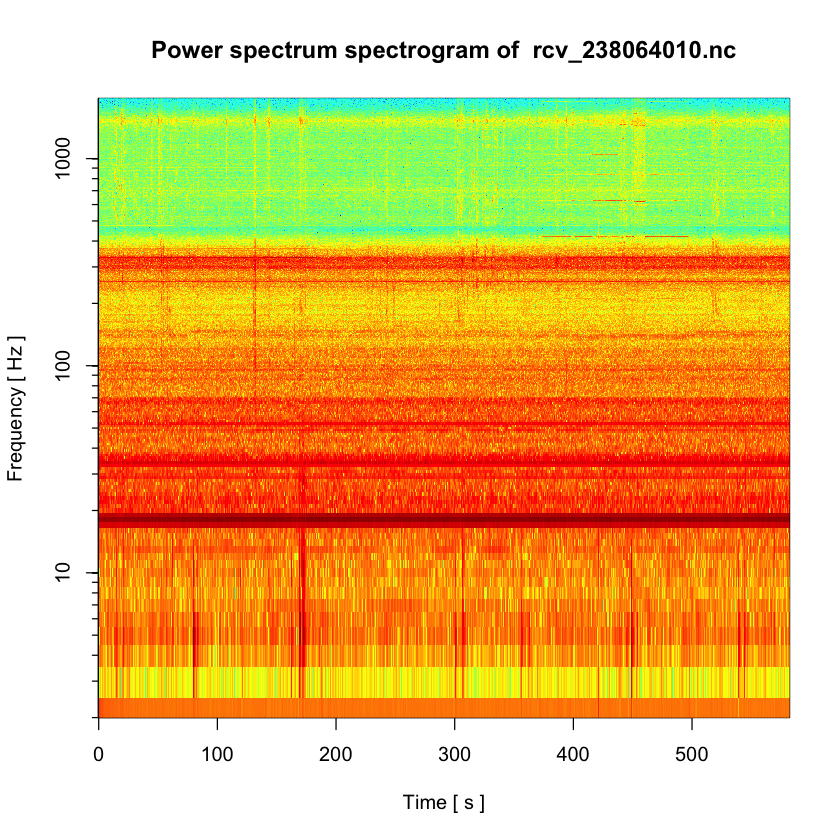

done in 2.806 s.


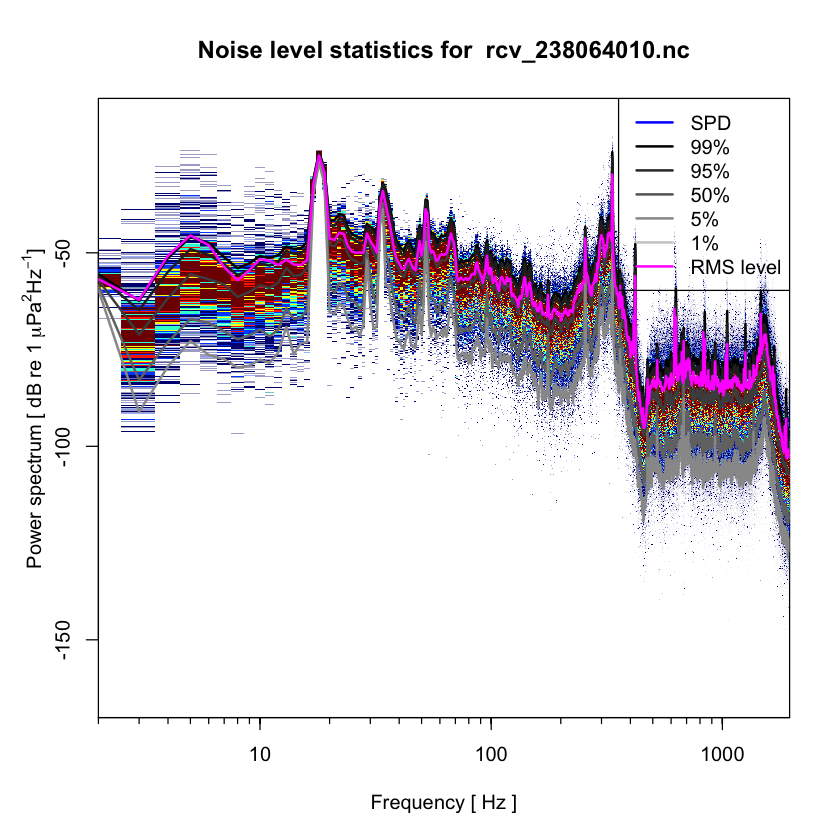

In [20]:
atype = "PowerSpec"
PAMGuide(fullfile=fname, isvector=isvector,y=y,atype=atype,plottype="Both", Fs=fs, envi=envi, vADC=vADC, Mh=Mh, G=G, calib=calib, Nbit=Nbit, ctype=ctype, outwrite=outwrite)

### Example: PSD analysis type

File length: 2277216 samples = 582.9673 s
File name: rcv_238064010.nc 
File length: 2277216 samples = 582.9673 s
Analysis type: PSD 
Plot type: Both 
Underwater measurement
Hydrophone sensitivity: -168 dB re 1 V/uPa
Preamplifier gain: 12 dB
ADC peak voltage: 2.5 V
Time segment length: 3906.25 samples = 1 s
Window function: Hann 
Window overlap: 50 %
Loading input file... done in 0.027 s.
System sensitivity correction factor, S =  -164.0  dB
Computing PSD...done in 0.785 s.
Plotting...done in 0.422 s.
Computing noise level statistics...

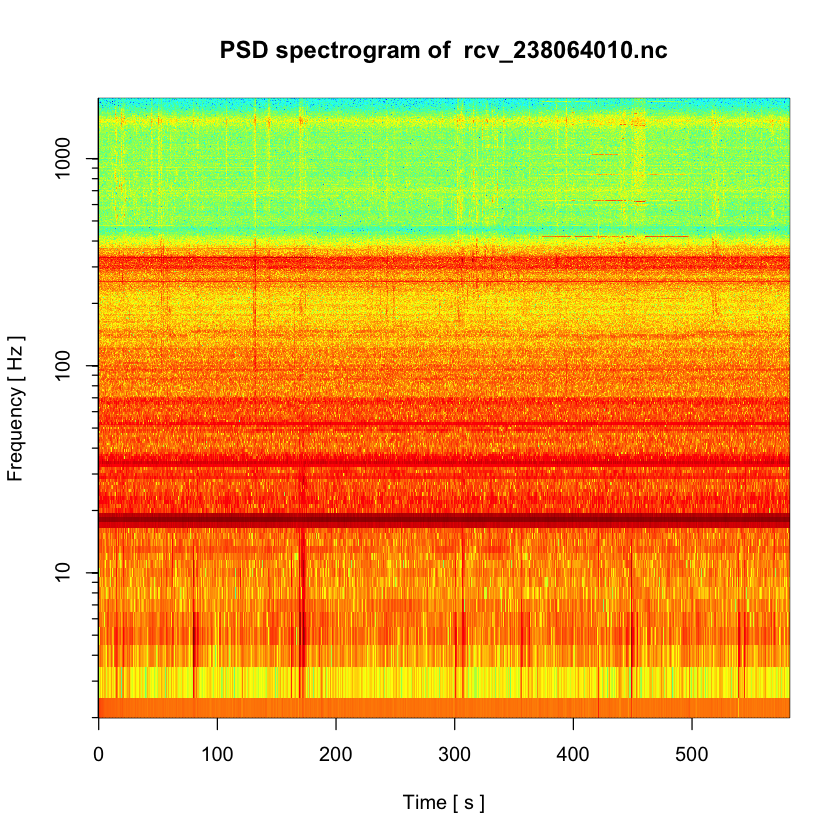

done in 2.592 s.


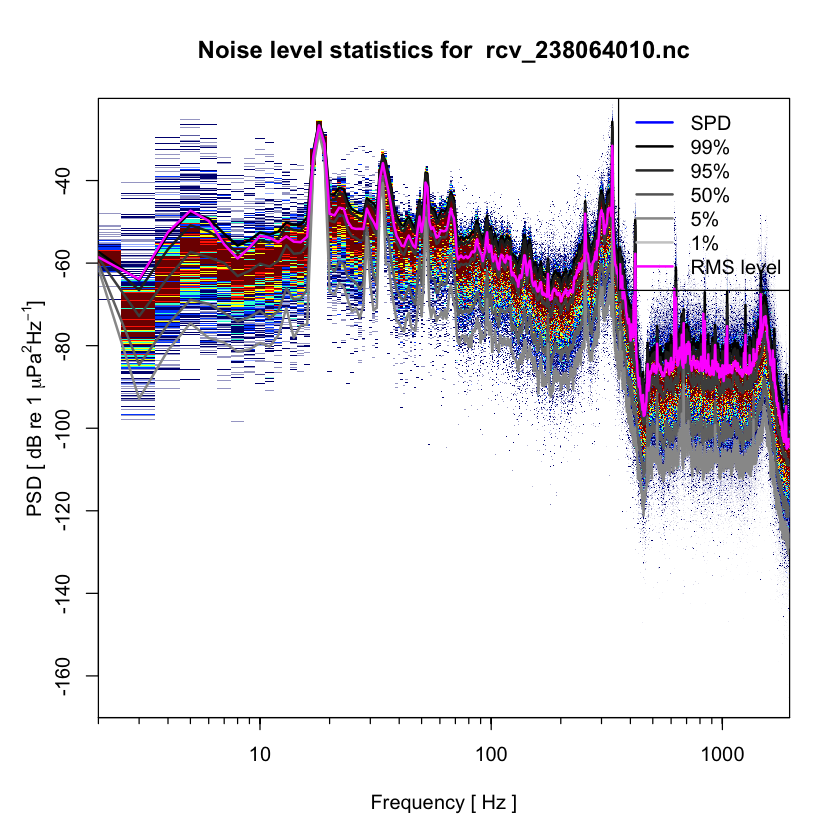

In [21]:
atype = "PSD"
PAMGuide(fullfile=fname, isvector=1,y=y,atype=atype,plottype="Both", Fs=fs, envi=envi, vADC=vADC, Mh=Mh, G=G, calib=calib, Nbit=24, ctype=ctype)

### Example: TOL analysis type

File length: 2277216 samples = 582.9673 s
File name: rcv_238064010.nc 
File length: 2277216 samples = 582.9673 s
Analysis type: TOL 
Plot type: Both 
Underwater measurement
Hydrophone sensitivity: -168 dB re 1 V/uPa
Preamplifier gain: 12 dB
ADC peak voltage: 2.5 V
Time segment length: 3906.25 samples = 1 s
Window function: Hann 
Window overlap: 50 %
Loading input file... done in 0.007 s.
System sensitivity correction factor, S =  -164.0  dB
Computing TOLs by DFT method...done in 0.506 s.
Plotting...done in 0.007 s.
Computing noise level statistics...

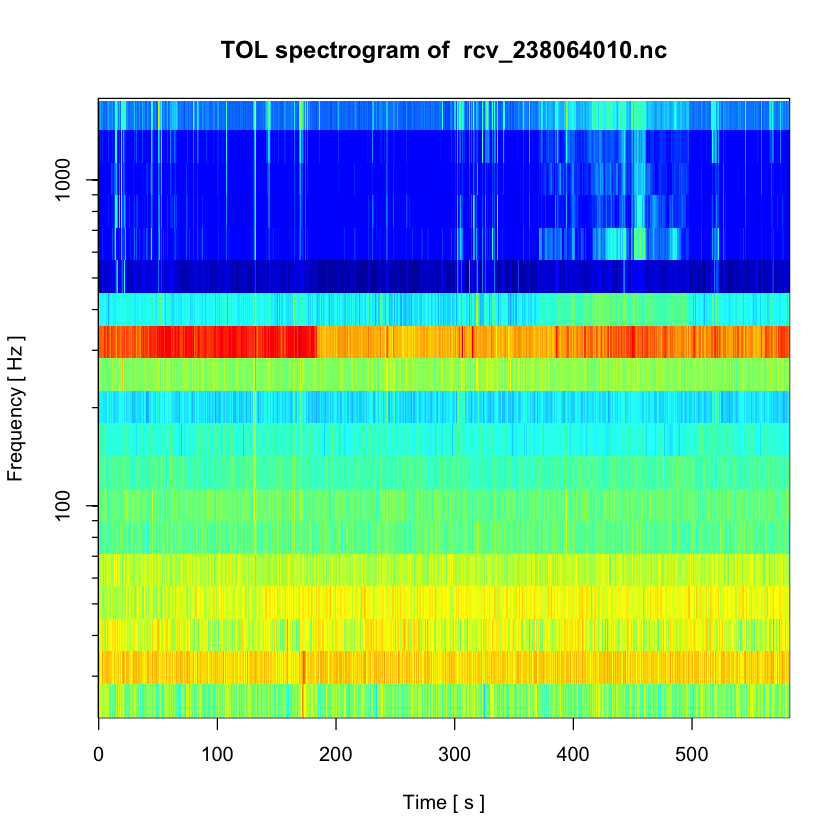

done in 0.037 s.


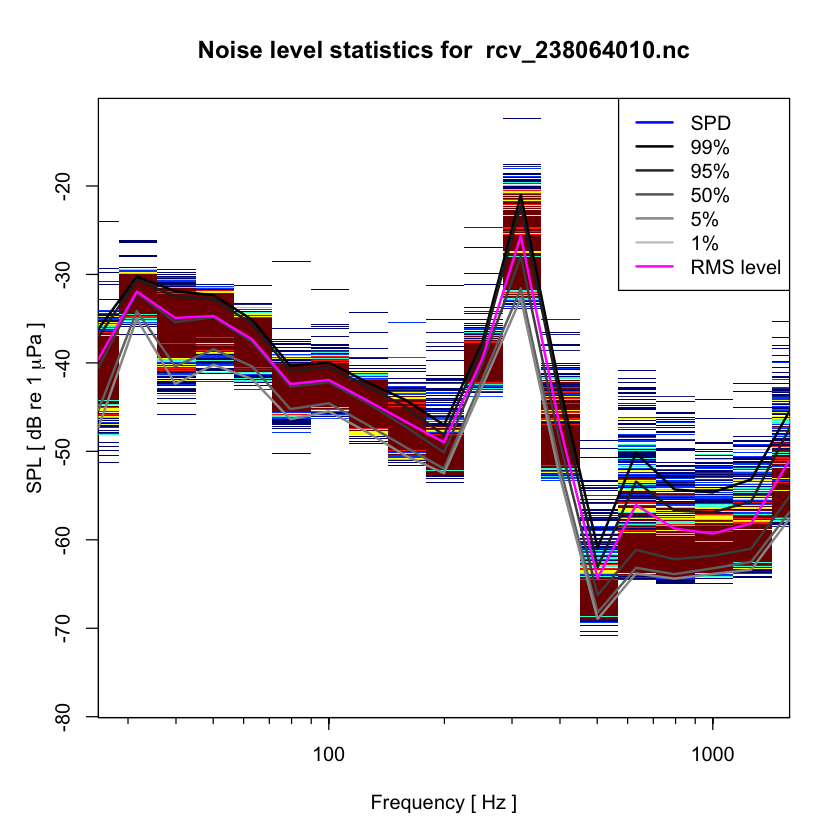

In [23]:
atype = "TOL"
PAMGuide(fullfile=fname, isvector=1,y=y,atype=atype,plottype="Both", Fs=fs, envi=envi, vADC=vADC, Mh=Mh, G=G, calib=calib, Nbit=24, ctype=ctype)

### Example: Broadband analysis type

File length: 2277216 samples = 582.9673 s
File name: rcv_238064010.nc 
File length: 2277216 samples = 582.9673 s
Analysis type: Broadband 
Plot type: Both 
Underwater measurement
Hydrophone sensitivity: -168 dB re 1 V/uPa
Preamplifier gain: 12 dB
ADC peak voltage: 2.5 V
Time segment length: 3906.25 samples = 1 s
Window function: Hann 
Window overlap: 50 %
Loading input file... done in 0.014 s.
System sensitivity correction factor, S =  -164.0  dB
Computing broadband level...done in 0.53 s.
Plotting...done in 0.004 s.
Computing noise level statistics...

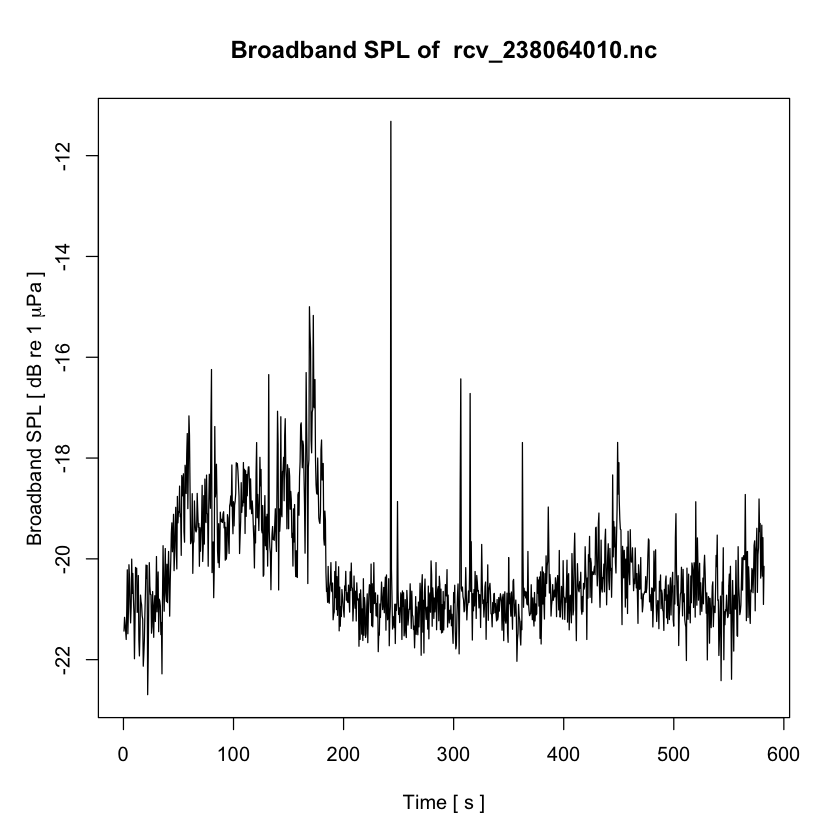

done in 0.004 s.

RMS level (mean SPL) =  -20.1 dB re 1 uPa
Median SPL =  -20.6 dB re 1 uPa
Mode SPL =  -20.7 dB re 1 uPa
SEL =  10.6 dB re 1 uPa^2 s. Note: for SEL measurements, set r = 0 (window overlap) and use default N.



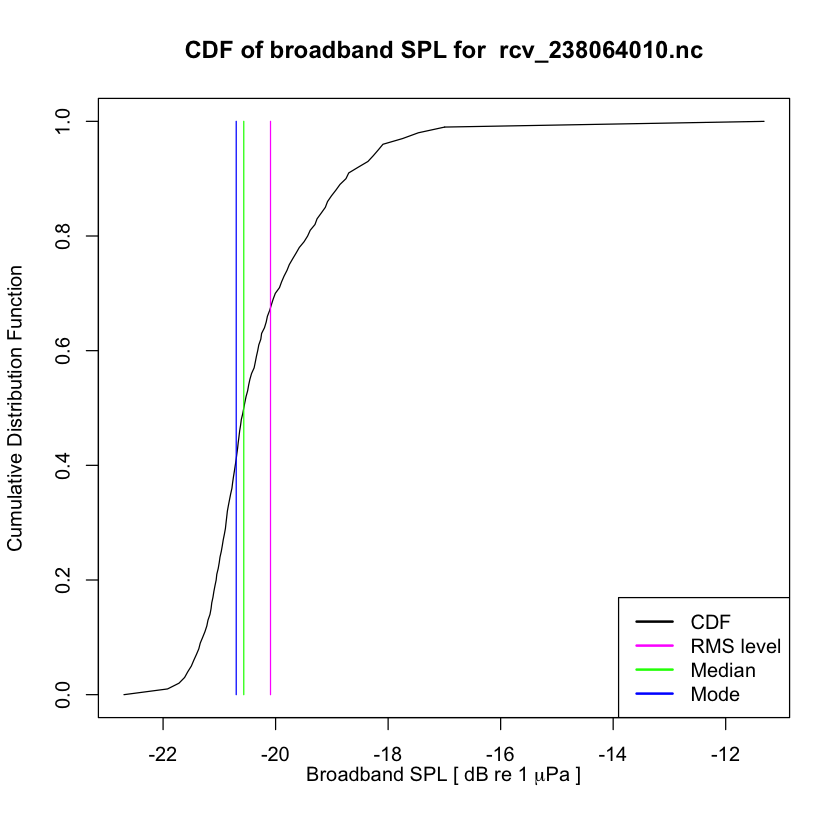

In [24]:
atype = "Broadband"
PAMGuide(fullfile="rcv_238064010.nc", isvector=1,y=y,atype=atype,plottype="Both", Fs=fs, envi=envi, vADC=vADC, Mh=Mh, G=G, calib=calib, Nbit=24, ctype=ctype)

### Example: Waveform analysis type

File length: 2277216 samples = 582.9673 s
File name: rcv_238064010.nc 
File length: 2277216 samples = 582.9673 s
Analysis type: Waveform 
Plot type: Both 
Underwater measurement
Hydrophone sensitivity: -168 dB re 1 V/uPa
Preamplifier gain: 12 dB
ADC peak voltage: 2.5 V
Time segment length: 3906.25 samples = 1 s
Window function: Hann 
Window overlap: 50 %
Loading input file... done in 0.013 s.
System sensitivity correction factor, S =  -164.0  dB
done in 0 s.
Plotting...done in 0.288 s.


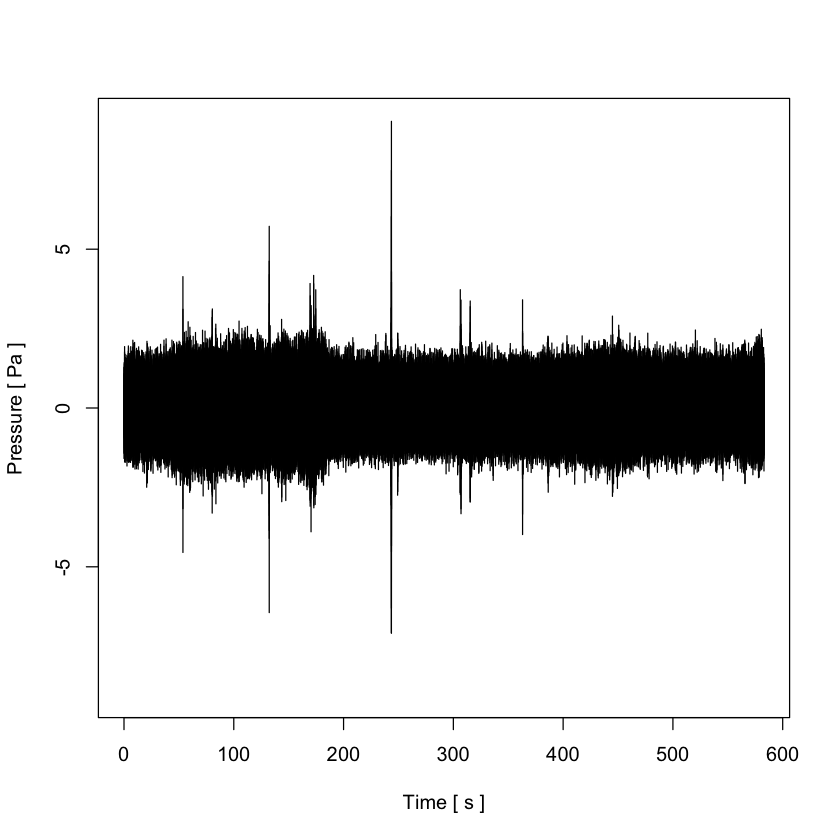

In [25]:
atype = "Waveform"
y <- ncvar_get(ncin, "samples", verbose = F)
PAMGuide(fullfile=fname, isvector=1,y=y,atype=atype,plottype="Both", Fs=fs, envi=envi, vADC=vADC, Mh=Mh, G=G, calib=calib, Nbit=24, ctype=ctype)